In [1]:
import numpy as np
import os
import dv_processing as dv
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd


import sys
sys.path.append('../')
from src.data.preprocessing import *
from src.data.custom_dataset import *


C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def aedat4_to_sequences(
        input_dir: str, 
        output_dir: str, 
        duration: int = 10,
        sequence_length: int = 300
    ):
    """
    Convert a directory of aedat4 files (with labels as subdirectories) to sequences of frames and save them as pytorch tensors.
    """
    df = pd.read_csv(os.path.join(input_dir, 'labels.csv'))

    for file in os.listdir(input_dir):
        if file.endswith('.aedat4'):
            print("Processing file:", file)
            file_path = os.path.join(input_dir, file)
            file_df = df[df['id'] == file.replace('.aedat4', '')] # 3 columns: id, start, end

            frames, labels = dv.dv_data_frame_tSlice(
                file_path=file_path,
                duration=duration
            )
            frames = preprocess_frames(frames)
            sequences = create_sequence(frames, sequence_length=sequence_length)


    # for label in os.listdir(input_dir):
    #     label_dir = os.path.join(input_dir, label)
    #     print("Processing label:", label)
    #     if os.path.isdir(label_dir):
    #         for file in os.listdir(label_dir):
    #             if file.endswith('.aedat4'):
    #                 print("Processing file:", file)
    #                 file_path = os.path.join(label_dir, file)

    #                 frames = dv_data_frame_tSlice(
    #                     file_path=file_path,
    #                     duration=duration
    #                 )
    #                 frames = preprocess_frames(frames)
    #                 sequences = create_sequence(frames, sequence_length=sequence_length)

    #                 label_output_dir = os.path.join(output_dir, label)
    #                 os.makedirs(label_output_dir, exist_ok=True)

    #                 for i, sequence in enumerate(sequences):
    #                     sequence_tensor = torch.stack(sequence)
    #                     torch.save(sequence_tensor, os.path.join(label_output_dir, f"{os.path.splitext(file)[0]}_seq_{i}.pt"))

In [9]:
for file in os.listdir('../data/raw_data'):
    if file.endswith('.aedat4'):
        print(file.replace('.aedat4', ''))

raw1
raw10
raw11
raw2
raw3
raw4
raw5
raw6
raw7
raw8
raw9


In [2]:
def dv_data_frame_tSlice(file_path, press_times_list, duration=10, encoding_type='accumulate' ):
    """
    Extract frames from a .aedat4 file using a time slice.
    Args:
        file_path: str
        duration (milliseconds): int
        press_times_list: list of time (every 2 elements are a pair of start time and end time)
        encoding_type: str ('accumulate', 'time_surface', 'custom')
    Returns:
        list[np.ndarray]: frames (each of shape (H, W))
        list[int]: labels (0 for no press and 1 for press)
    """
    capture = dv.io.MonoCameraRecording(file_path)
    
    frames = []
    labels = [] # 0 for no press and 1 for press
    if not capture.isEventStreamAvailable():
        raise RuntimeError("Input camera does not provide an event stream.")

    slicer = dv.EventStreamSlicer()
    if encoding_type == 'accumulate':
        encoding_func = ev_enc.accumulate_dv_encode
    elif encoding_type == 'time_surface':
        encoding_func = ev_enc.timesurface_dv_encode
    elif encoding_type == 'custom':
        encoding_func = ev_enc.custom_encode

    def slicing_callback(events: dv.EventStore):
        frame = encoding_func(events, capture.getEventResolution())
        frames.append(frame)
        
        if len(press_times_list) == 0:
            labels.append(0)
        else:
            event_start_time = events.getLowestTime()
            event_end_time = events.getHighestTime()
            label = 0
            for start, end in zip(press_times_list[::2], press_times_list[1::2]):
                if event_start_time <= end and event_end_time >= start:
                    label = 1
                    break
            labels.append(label)

    slicer.doEveryTimeInterval(timedelta(milliseconds=duration), slicing_callback)

    while capture.isRunning():
        events = capture.getNextEventBatch()
        if events is not None:
            slicer.accept(events)
    return frames, labels

In [20]:
input_dir = '../data/raw_data'
output_dir = '../data/seq'
duration = 10

press_df = pd.read_csv(os.path.join(input_dir, 'labels.csv'))
capture_info_df = pd.read_csv(os.path.join(input_dir, 'capture_info.csv'))

for file in os.listdir(input_dir):
    if file.endswith('.aedat4'):
        print("Processing file:", file)
        file_path = os.path.join(input_dir, file)
        file_prefix = file.replace('.aedat4', '')
        file_df = press_df.loc[press_df['id'] == file_prefix] # 3 columns: id, start, end
        press_times_list = np.array(file_df[['start', 'end']].values.flatten().tolist()) + capture_info_df.loc[capture_info_df['id'] == file_prefix, 'capture_start'].values[0]
        frames, labels = dv_data_frame_tSlice(
            file_path=file_path,
            press_times_list=press_times_list,
            duration=duration,
            encoding_type='accumulate'
        )
        frames = preprocess_frames(frames) # add transformations
        sequences, sequence_labels = create_sequence(frames, labels, sequence_length=300)
        
        os.makedirs(output_dir, exist_ok=True)
        for i, (sequence, sequence_label) in enumerate(zip(sequences, sequence_labels)):
            sequence_data = {
                'sequence': torch.stack(sequence),
                'label': torch.tensor(sequence_label)
            }
            torch.save(sequence_data, os.path.join(output_dir, f"{file_prefix}_seq_{i}.pt"))

Processing file: raw1.aedat4
Processing file: raw10.aedat4
Processing file: raw2.aedat4
Processing file: raw3.aedat4
Processing file: raw4.aedat4
Processing file: raw5.aedat4
Processing file: raw6.aedat4
Processing file: raw7.aedat4
Processing file: raw8.aedat4
Processing file: raw9.aedat4


In [ ]:
class CustomSequenceDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._make_dataset(self.root_dir)
        
    def _make_dataset(self, dir):
        paths = []
        for file in os.listdir(dir):
            if file.endswith('.pt'):
                paths.append(os.path.join(dir, file))
        return paths

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            sequence (torch.Tensor): A sequence of frames of shape (sequence_length, channels, height, width)
            target (int): Target class index
        """
        path = self.samples[idx]
        sequence_data = torch.load(path)
        return sequence_data['sequence'], sequence_data['label']

In [4]:
dataset = CustomSequenceDataset(root_dir='../data/seq')

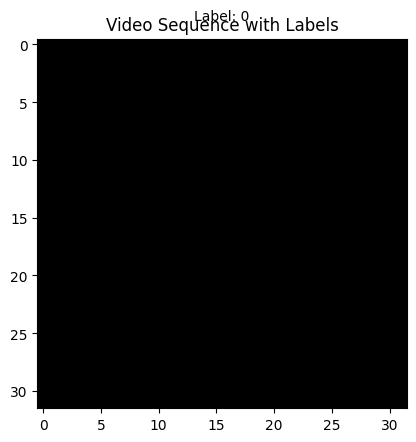

In [19]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video


def visualize_sequence(sequence, labels):
    """
    Visualize the video sequence with corresponding labels.
    
    Args:
        sequence (torch.Tensor): A sequence of frames of shape (sequence_length, channels, height, width)
        labels (torch.Tensor): Labels for each frame in the sequence of shape (sequence_length)
    """
    sequence = sequence.permute(0, 2, 3, 1).numpy()  # Convert to (sequence_length, height, width, channels)
    labels = labels.numpy()

    fig, ax = plt.subplots()
    ax.set_title('Video Sequence with Labels')
    frame_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')

    def update(frame_idx):
        ax.imshow(sequence[frame_idx], cmap='gray')
        frame_text.set_text(f'Label: {labels[frame_idx]}')

    ani = animation.FuncAnimation(fig, update, frames=len(sequence), interval=100)
    ani.save('sequence.mp4', writer='ffmpeg')
    plt.show()

# Example usage
dataset = CustomSequenceDataset(root_dir='../data/seq')
sequence, labels = dataset[1]  # Get the sequence and labels
visualize_sequence(sequence, labels)

# Visualize the video
Video('sequence.mp4', embed=True)

In [2]:
train_dataloader, test_dataloader = create_dataloader(
    data_dir='../data/seq_data',
    batch_size=8,
    num_workers=1,
)


Total number of sequences: 307
Number of training sequences: 245
Number of test sequences: 62
Training DataLoader:
torch.Size([8, 300, 1, 32, 32]) torch.Size([8, 300])
Test DataLoader:
torch.Size([8, 300, 1, 32, 32]) torch.Size([8, 300])
Number of training batches: 31
Number of test batches: 8


In [4]:
for sequence, labels in train_dataloader:
    print(sequence.shape, labels.shape)
    print(labels.numel())
    break

torch.Size([8, 300, 1, 32, 32]) torch.Size([8, 300])
2400
